In [1]:
!pip install h2o
!pip install auto-sklearn
!pip install tpot
!pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 51.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 97.1 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [3]:
!pip install pycaret[full]
!pip install lightgbm --upgrade
!pip install xgboost --upgrade


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlb.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/nifty-50-nse/NSEI.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.dropna().sort_values(by='Date')

# Feature Engineering: Create lag features
for lag in range(1, 4):
    data[f'Open_Lag{lag}'] = data['Open'].shift(lag)
    data[f'Close_Lag{lag}'] = data['Close'].shift(lag)

# Drop rows with NaN after creating lag features
data = data.dropna()

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'Close', 'High', 'Low', 'Volume']])

# Prepare data for LSTM
def create_sequences(data, target_col, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_col])
    return np.array(X), np.array(y)

# Create sequences for Open and Close price predictions
X, y_open = create_sequences(scaled_data, target_col=0)
_, y_close = create_sequences(scaled_data, target_col=1)

# Split data into training and testing sets
X_train, X_test, y_open_train, y_open_test = train_test_split(X, y_open, test_size=0.2, random_state=42)
_, _, y_close_train, y_close_test = train_test_split(X, y_close, test_size=0.2, random_state=42)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    
    # Add LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):  # Search 1-3 LSTM layers
        model.add(tf.keras.layers.LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh']),
            return_sequences=(i != hp.get('num_layers') - 1),  # False for the last layer
        ))
    
    # Add Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 2)):  # Search 1-2 Dense layers
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
    
    # Output layer
    model.add(tf.keras.layers.Dense(1))
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

# Initialize Keras Tuner for hyperparameter optimization
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=20,
    factor=3,
    directory='automl_dir',
    project_name='predict_open_close'
)

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters for Open price prediction
tuner.search(X_train, y_open_train, validation_data=(X_test, y_open_test), callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model_open = tuner.hypermodel.build(best_hps)

# Train the best model for Open price
history_open = best_model_open.fit(
    X_train, y_open_train,
    validation_data=(X_test, y_open_test),
    epochs=50,
    callbacks=[stop_early],
    verbose=2
)

# Predict Open prices
pred_open = best_model_open.predict(X_test)

# Repeat for Close price prediction
tuner.search(X_train, y_close_train, validation_data=(X_test, y_close_test), callbacks=[stop_early])
best_model_close = tuner.hypermodel.build(best_hps)

history_close = best_model_close.fit(
    X_train, y_close_train,
    validation_data=(X_test, y_close_test),
    epochs=50,
    callbacks=[stop_early],
    verbose=2
)

# Predict Close prices
pred_close = best_model_close.predict(X_test)

# Display results
print("Next Day Open Predictions:", pred_open[:5].flatten())
print("Next Day Close Predictions:", pred_close[:5].flatten())


Trial 30 Complete [00h 00m 17s]
val_mae: 0.0038535608910024166

Best val_mae So Far: 0.003234683535993099
Total elapsed time: 00h 04m 50s
Epoch 1/50
104/104 - 4s - 42ms/step - loss: 0.0102 - mae: 0.0451 - val_loss: 2.6222e-05 - val_mae: 0.0037
Epoch 2/50
104/104 - 0s - 3ms/step - loss: 3.5183e-05 - mae: 0.0041 - val_loss: 3.5756e-05 - val_mae: 0.0045
Epoch 3/50
104/104 - 0s - 3ms/step - loss: 3.2626e-05 - mae: 0.0040 - val_loss: 2.2122e-05 - val_mae: 0.0034
Epoch 4/50
104/104 - 0s - 3ms/step - loss: 3.3089e-05 - mae: 0.0041 - val_loss: 2.9940e-05 - val_mae: 0.0041
Epoch 5/50
104/104 - 0s - 3ms/step - loss: 3.0040e-05 - mae: 0.0038 - val_loss: 2.5509e-05 - val_mae: 0.0038
Epoch 6/50
104/104 - 0s - 3ms/step - loss: 2.8263e-05 - mae: 0.0038 - val_loss: 2.9039e-05 - val_mae: 0.0037
Epoch 7/50
104/104 - 0s - 3ms/step - loss: 2.9836e-05 - mae: 0.0039 - val_loss: 2.0926e-05 - val_mae: 0.0032
Epoch 8/50
104/104 - 0s - 3ms/step - loss: 2.8007e-05 - mae: 0.0037 - val_loss: 2.1202e-05 - val_mae: 

In [11]:
import matplotlib.pyplot as plt

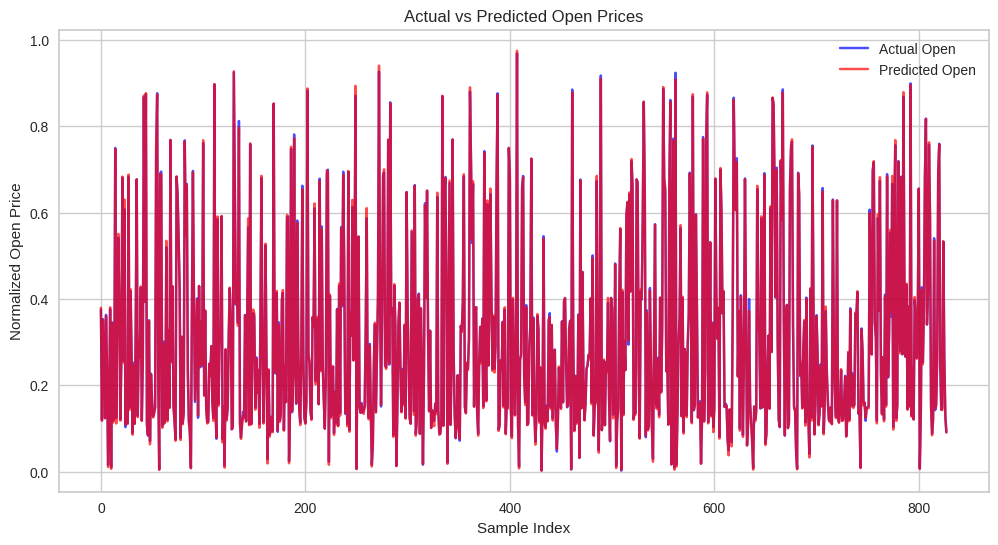

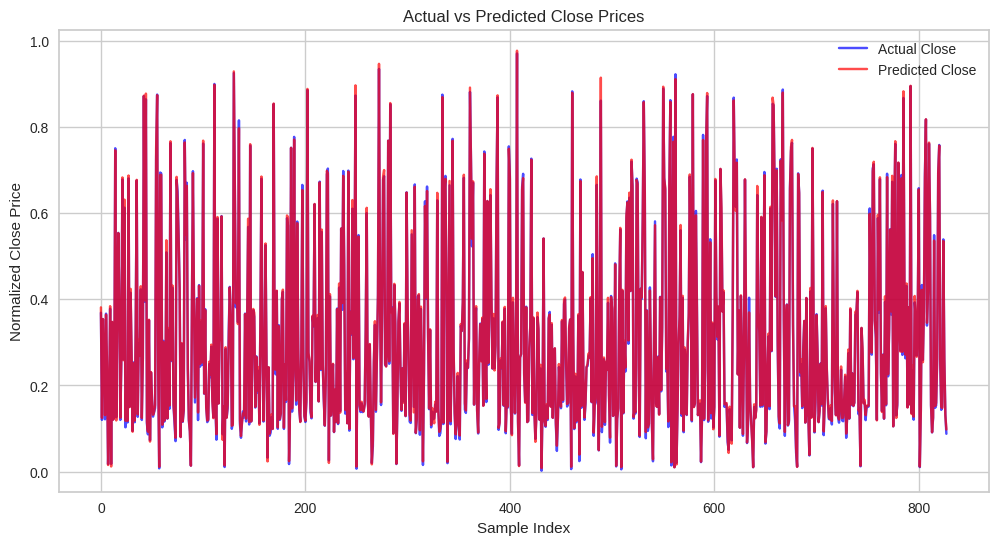

In [12]:
# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_open_test)), y_open_test, label='Actual Open', color='blue', alpha=0.7)
plt.plot(range(len(pred_open)), pred_open, label='Predicted Open', color='red', alpha=0.7)
plt.title("Actual vs Predicted Open Prices")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Open Price")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_close_test)), y_close_test, label='Actual Close', color='blue', alpha=0.7)
plt.plot(range(len(pred_close)), pred_close, label='Predicted Close', color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()
